#### Packages

In [1]:
import numpy as np
import os
import cv2
from time import time
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

#### Functions

In [2]:
## gives normalized features, labels, and t including a binary tensor for each label
def process(x):
    feature_x = [features for features, labels in x]
    label_x = [labels for features, labels in x]
    feature_x = np.array(feature_x)
    feature_x = feature_x / 255 # use of 255 to normalize is very common
    feature_x = feature_x.reshape(-1,128,128,1) # target size is 128*128, gray; only 1 channel
    label_x = np.array(label_x).reshape(-1,1)
    encoder = OneHotEncoder()
    t = encoder.fit_transform(label_x)
    t = t.toarray()
    return feature_x, t
## gives plots of loss and accuracy values with respect to epochs - associated with each training step
def model_plot(history):
    fig = plt.figure()
    # loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss - Epoch')
    plt.ylabel('Loss Function Value')
    plt.xlabel('Epoch Number')
    plt.legend(['Training', 'Validation'])
    # accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Accuracy - Epoch')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch Number')
    plt.legend(['Training', 'Validation'])
    fig.tight_layout()
    plt.show()
## apply model to the valid or test set and gives loss, acuracy, and confusion matrix    
def post_processing(model, feature, label, t):
    score = model.evaluate(feature, t)
    pred_t = model.predict(feature)
    pred_label = np.argmax(pred_t, axis = 1)
    cm = confusion_matrix(label, pred_label)
    plot_confusion_matrix(conf_mat = cm, figsize = (5,5), class_names = ["No BG: Class 0", "w| BG: Class 1"])
    plt.show()
    return score

#### Image Processing

In [3]:
print("Step 1: Process images and prepare datasets for CNN")
start1 = time()
## read images in subdirectories
path_0 = r"C:\Users\sinas\Yan's Project\New-Cropped\Original_Images_Balanced\0"
path_1 = r"C:\Users\sinas\Yan's Project\New-Cropped\Original_Images_Balanced\1"
x_0 = []
for file in os.listdir(path_0):
    img = cv2.imread(path_0 + "//" + file, cv2.IMREAD_GRAYSCALE) # convert to gray scale
    img = cv2.resize(img, (128,128)) # in case images are not the same size
    x_0.append([img, 0]) # add labels
x_1 = []
for file in os.listdir(path_1):
    img = cv2.imread(path_1 + "//" + file, cv2.IMREAD_GRAYSCALE) # convert to gray scale
    img = cv2.resize(img, (128,128)) # in case images are not the same size
    x_1.append([img, 1]) # add labels
## split dataset with balanced number of examples asscoiated with two categorries (60% train, 20% valid, and 20% test)
x_train = x_0[:int(0.6 * len(x_0))] + x_1[:int(0.6 * len(x_1))] # when using only training set to learn the model
x_valid = x_0[int(0.6 * len(x_0)):int(0.8 * len(x_0))] + x_1[int(0.6 * len(x_1)):int(0.8 * len(x_1))]
x_test = x_0[int(0.8 * len(x_0)):] + x_1[int(0.8 * len(x_1)):]
x_train_TV = x_train + x_valid # when using both training and validation sets to learn the model
x_train_TVT = x_0 + x_1 # when using the whole dataset to learn the model
## shuffle to remove the bias and the order
np.random.seed(100)  
np.random.shuffle(x_train)
np.random.shuffle(x_valid)
np.random.shuffle(x_train_TV)
np.random.shuffle(x_test)
np.random.shuffle(x_train_TVT)
## use process function to get features, labels, and t to be used in CNN
feature_train_T, t_train_T = process(x_train)
feature_valid, t_valid = process(x_valid)
label_valid = np.argmax(t_valid, axis = 1)
feature_train_TV, t_train_TV = process(x_train_TV)
feature_test, t_test = process(x_test)
label_test = np.argmax(t_test, axis = 1)
feature_train_TVT, t_train_TVT = process(x_train_TVT)
end1 = time()
print(f"The execution time to load and prepare images for CNN is {str(end1 - start1)} seconds.")
print("------------------------------------------------------------------------------------------------------------")

Step 1: Process images and prepare datasets for CNN
The execution time to load and prepare images for CNN is 11.998384475708008 seconds.
------------------------------------------------------------------------------------------------------------


#### CNN Model

In [4]:
model = Sequential()
model.add(Conv2D(16, kernel_size = 3, strides = 2, input_shape = (128,128,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = 4, strides = 2))
model.add(Conv2D(32, kernel_size = 4, strides = 1))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = 3, strides = 2))
model.add(Conv2D(64, kernel_size = 3, strides = 1))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = 3, strides = 2))
model.add(Flatten())
model.add(Dense(100))
model.add(BatchNormalization())
# model.add(Dropout(0.5)) # it could be here instead of being after activation
model.add(Activation('relu'))
model.add(Dropout(0.5)) # combat overfitting
model.add(Dense(2, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 63, 63, 16)        160       
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 63, 63, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 32)        8224      
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 27, 27, 32)        0

#### Train with Training Set and Apply to Validation Set

Step 2: Here we use only training set to learn the model and apply that to the validation set
------------------------------------------------------------------------------------------------------------
Epoch 1/100
120/120 [==============================] - 14s 113ms/step - loss: 0.0918 - accuracy: 0.9716 - val_loss: 1.4010 - val_accuracy: 0.5000
Epoch 2/100
120/120 [==============================] - 13s 110ms/step - loss: 0.0289 - accuracy: 0.9914 - val_loss: 1.8214 - val_accuracy: 0.5000
Epoch 3/100
120/120 [==============================] - 13s 110ms/step - loss: 0.0210 - accuracy: 0.9945 - val_loss: 1.4904 - val_accuracy: 0.5000
Epoch 4/100
120/120 [==============================] - 13s 111ms/step - loss: 0.0200 - accuracy: 0.9937 - val_loss: 0.6004 - val_accuracy: 0.5891
Epoch 5/100
120/120 [==============================] - 13s 112ms/step - loss: 0.0100 - accuracy: 0.9974 - val_loss: 0.0362 - val_accuracy: 0.9945
Epoch 6/100
120/120 [==============================] - 14s 117ms/st

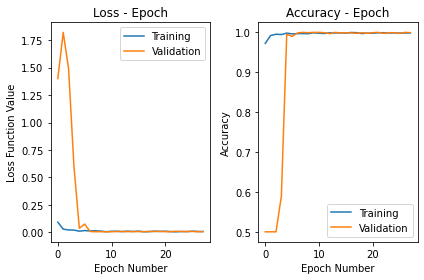

------------------------------------------------------------------------------------------------------------
Validation Loss, Accuracy, and Confusion Matrix:
40/40 [==============================] - 1s 22ms/step - loss: 0.0056 - accuracy: 0.9984


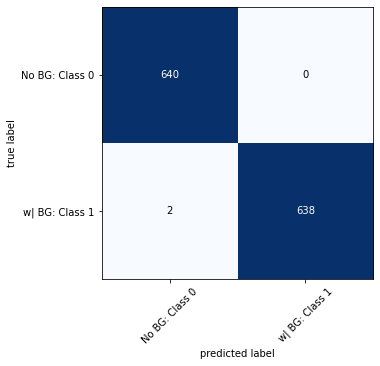

Validation Loss: 0.005645424593240023
Validation Accuracy: 0.9984375238418579
------------------------------------------------------------------------------------------------------------
Execution Times:
The execution time to learn the model using only training set is 444.76470017433167 seconds.
The execution time to apply the model to the validation set is 2.119004487991333 seconds.
------------------------------------------------------------------------------------------------------------


In [5]:
## for early stopping to combat overfitting
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 20, min_delta = 0.001, mode = 'max')
print("Step 2: Here we use only training set to learn the model and apply that to the validation set")
print("------------------------------------------------------------------------------------------------------------")
## train the model
start2 = time()
model.compile(optimizer = RMSprop(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])
history_T = model.fit(feature_train_T, t_train_T, validation_data = (feature_valid, t_valid), epochs = 100, callbacks = [early_stopping])
print("------------------------------------------------------------------------------------------------------------")
model.save("model_T.h5")
model_plot(history_T)
end2 = time()
print("------------------------------------------------------------------------------------------------------------")
print("Validation Loss, Accuracy, and Confusion Matrix:")
start3 = time()
score_valid = post_processing(model, feature_valid, label_valid, t_valid)
end3 = time()
print('Validation Loss:', score_valid[0])
print('Validation Accuracy:', score_valid[1])
print("------------------------------------------------------------------------------------------------------------")
print("Execution Times:")
print(f"The execution time to learn the model using only training set is {str(end2 - start2)} seconds.")
print(f"The execution time to apply the model to the validation set is {str(end3 - start3)} seconds.")
print("------------------------------------------------------------------------------------------------------------")

#### Train with Training and Validation Sets and Apply to Test Set

Step 3: Here we use both training and validation sets to learn the model and apply that to the test set
------------------------------------------------------------------------------------------------------------
Epoch 1/100
160/160 [==============================] - 20s 126ms/step - loss: 0.0050 - accuracy: 0.9980 - val_loss: 0.0065 - val_accuracy: 0.9969
Epoch 2/100
160/160 [==============================] - 20s 124ms/step - loss: 0.0068 - accuracy: 0.9982 - val_loss: 0.0108 - val_accuracy: 0.9969
Epoch 3/100
160/160 [==============================] - 20s 125ms/step - loss: 0.0052 - accuracy: 0.9982 - val_loss: 0.0135 - val_accuracy: 0.9969
Epoch 4/100
160/160 [==============================] - 20s 127ms/step - loss: 0.0041 - accuracy: 0.9988 - val_loss: 0.0049 - val_accuracy: 0.9984
Epoch 5/100
160/160 [==============================] - 21s 128ms/step - loss: 0.0070 - accuracy: 0.9980 - val_loss: 0.0038 - val_accuracy: 0.9992
Epoch 6/100
160/160 [==============================] - 20

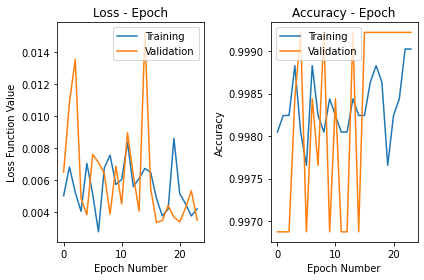

------------------------------------------------------------------------------------------------------------
Test Loss, Accuracy, and Confusion Matrix:
40/40 [==============================] - 1s 25ms/step - loss: 0.0053 - accuracy: 0.9984


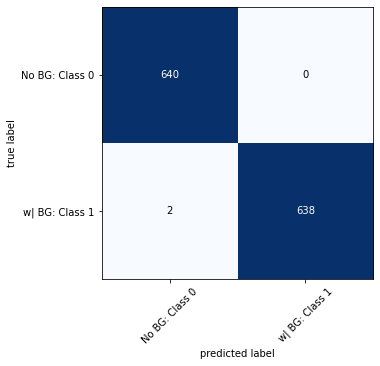

Test Loss: 0.005315384827554226
Test Accuracy: 0.9984375238418579
------------------------------------------------------------------------------------------------------------
Execution Times:
The execution time to learn the model using both training and validation sets is 525.2178919315338 seconds.
The execution time to apply the model to the test set is 2.507153272628784 seconds.
------------------------------------------------------------------------------------------------------------


In [6]:
# early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 20, min_delta = 0.001, mode = 'max')
print("Step 3: Here we use both training and validation sets to learn the model and apply that to the test set")
print("------------------------------------------------------------------------------------------------------------")
## train the model
start3 = time()
model.compile(optimizer = RMSprop(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])
history_TV = model.fit(feature_train_TV, t_train_TV, validation_data = (feature_valid, t_valid), epochs = 100, callbacks = [early_stopping])
print("------------------------------------------------------------------------------------------------------------")
model.save("model_TV.h5")
model_plot(history_TV)
end3 = time()
print("------------------------------------------------------------------------------------------------------------")
print("Test Loss, Accuracy, and Confusion Matrix:")
start4 = time()
score_test = post_processing(model, feature_test, label_test, t_test)
end4 = time()
print('Test Loss:', score_test[0])
print('Test Accuracy:', score_test[1])
print("------------------------------------------------------------------------------------------------------------")
print("Execution Times:")
print(f"The execution time to learn the model using both training and validation sets is {str(end3 - start3)} seconds.")
print(f"The execution time to apply the model to the test set is {str(end4 - start4)} seconds.")
print("------------------------------------------------------------------------------------------------------------")

#### Train with Whole Dataset

Step 4: Here we use the whole dataset to learn the model
------------------------------------------------------------------------------------------------------------
Epoch 1/100
200/200 [==============================] - 28s 139ms/step - loss: 0.0038 - accuracy: 0.9989 - val_loss: 0.0036 - val_accuracy: 0.9992
Epoch 2/100
200/200 [==============================] - 28s 139ms/step - loss: 0.0062 - accuracy: 0.9981 - val_loss: 0.0038 - val_accuracy: 0.9992
Epoch 3/100
200/200 [==============================] - 29s 145ms/step - loss: 0.0049 - accuracy: 0.9983 - val_loss: 0.0039 - val_accuracy: 0.9992
Epoch 4/100
200/200 [==============================] - 31s 156ms/step - loss: 0.0030 - accuracy: 0.9991 - val_loss: 0.0082 - val_accuracy: 0.9969
Epoch 5/100
200/200 [==============================] - 34s 170ms/step - loss: 0.0046 - accuracy: 0.9989 - val_loss: 0.0036 - val_accuracy: 0.9992
Epoch 6/100
200/200 [==============================] - 29s 147ms/step - loss: 0.0052 - accuracy: 0.9984 

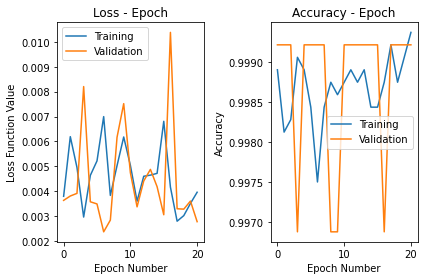

------------------------------------------------------------------------------------------------------------
Execution Time:
The execution time to learn the model using the whole dataset is 618.6425569057465 seconds.
------------------------------------------------------------------------------------------------------------


In [7]:
# early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 20, min_delta = 0.001, mode = 'max')
print("Step 4: Here we use the whole dataset to learn the model")
print("------------------------------------------------------------------------------------------------------------")
start5 = time()
model.compile(optimizer = RMSprop(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])
history_TVT = model.fit(feature_train_TVT, t_train_TVT, validation_data = (feature_valid, t_valid), epochs = 100, callbacks = [early_stopping])
print("------------------------------------------------------------------------------------------------------------")
model.save("model_TVT.h5")
model_plot(history_TVT)
end5 = time()
print("------------------------------------------------------------------------------------------------------------")
print("Execution Time:")
print(f"The execution time to learn the model using the whole dataset is {str(end5 - start5)} seconds.")
print("------------------------------------------------------------------------------------------------------------")